In [1]:
!pip install --upgrade plotly -q

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/LidarObjectDetection/VoxelNet

/content/gdrive/MyDrive/Colab Notebooks/LidarObjectDetection/VoxelNet


In [4]:
%load_ext autoreload
%autoreload 2
from data.dataset import KittiDataset
from data.dataset import detection_collate
from config import config as cfg
from torch.utils import data
import pathlib


# dataset
dataset_path = pathlib.Path.cwd() / "data/validation"
print("## data path:", dataset_path)
dataset=KittiDataset(dataset_path, cfg)
data_loader = data.DataLoader(dataset, batch_size=1, shuffle=True, 
                              num_workers=1, collate_fn=detection_collate,
                              pin_memory=False)

voxel_features, voxel_coords, pos_equal_one, neg_equal_one, targets, images, \
pointclouds, calibs, ids= next(iter(data_loader))

## data path: /content/gdrive/MyDrive/Colab Notebooks/LidarObjectDetection/VoxelNet/data/validation



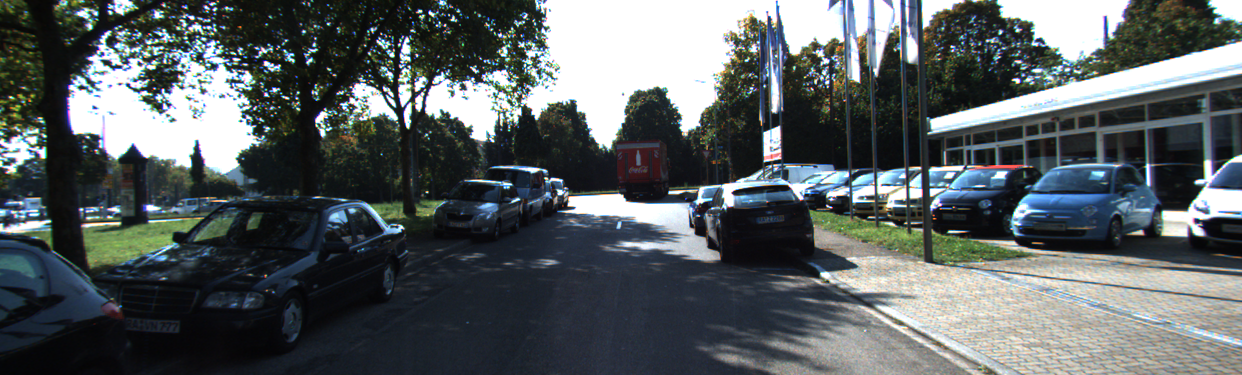

In [5]:
import plotly.express as px
import numpy as np
import cv2
img = images[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = px.imshow(img)
fig.show()

In [6]:
import plotly.graph_objs as go

def plotPointCloud(lidar, title, sampling=10):
    layout = go.Layout(
        scene=dict(aspectmode='data'),
        title=title,
    )
    pointcloud = go.Scatter3d(
        x=lidar['x'][::sampling],
        y=lidar['y'][::sampling],
        z=lidar['z'][::sampling],
        mode='markers',
        marker=dict(
            size=1,
            colorscale='Jet',
            opacity=0.8,
            color = lidar['i'],
            colorbar=dict(thickness=20, title='intensity'),
        )
    )
    data = [pointcloud]
    
    # for _, row in annotation.iterrows():
    #     x, y, z = getCorners(row)
    #     cube = go.Mesh3d(
    #         # 8 vertices of a cube
    #         x=x,
    #         y=y,
    #         z=z,
    #         i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
    #         j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
    #         k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
    #         opacity=0.6,
    #         color='#DC143C',
    #         flatshading = True
    #     )
    #     data.append(cube)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [7]:
pointcloud = pointclouds[0]
pointcloud_dict = {
    'x': pointcloud[:,0],
    'y': pointcloud[:,1],
    'z': pointcloud[:,2],
    'i': pointcloud[:,3],
}
plotPointCloud(pointcloud_dict, 'Original point cloud', sampling=1)

In [8]:
voxel_feature = voxel_features[voxel_coords[:,0]==0, ::]
print(voxel_feature.shape)
voxel_feature = voxel_feature.reshape(-1,7)
print(voxel_feature.shape)
voxel_feature_dict = {
    'x': voxel_feature[:,0],
    'y': voxel_feature[:,1],
    'z': voxel_feature[:,2],
    'i': voxel_feature[:,3],
}
plotPointCloud(voxel_feature_dict, 'Voxel feature', sampling=1)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
voxel_coord = voxel_coords[voxel_coords[:,0]==0,::]
voxel_coord = voxel_coord[::,1:] * (cfg.vd, cfg.vh, cfg.vw) \
              + (cfg.xrange[0], cfg.yrange[0], cfg.zrange[0])
voxel_coord_dict = {
    'x': voxel_coord[:,0],
    'y': voxel_coord[:,1],
    'z': voxel_coord[:,2],
    'i': voxel_coord[:,2],
}
plotPointCloud(voxel_coord_dict, 'Voxel coordinate', sampling=1)

In [10]:
import plotly.express as px
target = targets[0]
fig = px.imshow(target.sum(axis=-1))
fig.show()

In [11]:
boxes = target.reshape(-1,14)[target.reshape(-1,14).sum(axis=-1)!=0.,:]

In [12]:
boxes.shape

(94, 14)

In [13]:
target.reshape(-1,14).shape

(35200, 14)

In [14]:
[x, y, z, l, w, h, theta] = boxes[0][:7]

In [15]:
print(x, y, z, l, w, h, theta)

0.0 0.0 0.0 0.0 0.0 0.0 0.0


In [16]:
anchors = cfg.anchors
anchors.shape

(200, 176, 2, 7)

In [17]:
anchors_d = np.sqrt(anchors[:,:,:, 4] ** 2 + anchors[:,:,:, 5] ** 2)

In [18]:
target = np.copy(targets[0])
_target = target.reshape(200,176,2,7)
_target[:,:,:,0] = _target[:,:,:,0] * anchors_d + anchors[:,:,:, 0]
_target[:,:,:,1] = _target[:,:,:,1] * anchors_d + anchors[:,:,:, 1]
_target[:,:,:,2] = _target[:,:,:,2] * anchors[:,:,:, 3] + anchors[:,:,:, 2]
_target[:,:,:,3] = np.exp(_target[:,:,:,3]) * _target[:,:,:,3]
_target[:,:,:,4] = np.exp(_target[:,:,:,4]) * _target[:,:,:,4]
_target[:,:,:,5] = np.exp(_target[:,:,:,5]) * _target[:,:,:,5]
_target[:,:,:,6] += _target[:,:,:,6]

pos_equal_one_mask = pos_equal_one[0]
for i in range(7):
  _target[:,:,:,i] *= pos_equal_one_mask 

fig = px.imshow(_target.sum(axis=-1).sum(axis=-1))
fig.show()
boxes = _target.reshape(-1, 7)
boxes = boxes[boxes.sum(axis=-1) != 0,:].tolist()

In [19]:
def getCorners(x, y, z, l, w, h, yaw):
    box_corners = np.array([  
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2], \
            [0, 0, 0, 0, h, h, h, h]])
    
    rot_mat = np.array([
            [np.cos(yaw), -np.sin(yaw), 0.0],
            [np.sin(yaw), np.cos(yaw), 0.0],
            [0.0, 0.0, 1.0]])
    
    box_corners = np.matmul(rot_mat, box_corners)
    translation = np.array([x, y, z])
    box_corners = box_corners + np.tile(translation,(8,1)).transpose()
    
    return box_corners[0,:].tolist(), \
           box_corners[1,:].tolist(), \
           box_corners[2,:].tolist()

In [24]:
import plotly.graph_objs as go

def plotPointCloud(lidar, boxes, title, sampling=10):
    layout = go.Layout(
        scene=dict(aspectmode='data'),
        title=title,
    )
    pointcloud = go.Scatter3d(
        x=lidar['x'][::sampling],
        y=lidar['y'][::sampling],
        z=lidar['z'][::sampling],
        mode='markers',
        marker=dict(
            size=1,
            colorscale='Jet',
            opacity=0.8,
            color = lidar['i'],
            colorbar=dict(thickness=20, title='intensity'),
        )
    )
    data = [pointcloud]
    
    for box in boxes:
      x, y, z, h, w, l, yaw = box
      x, y, z = getCorners(x, y, z, l*20, w*20, h*20, yaw)
      cube = go.Mesh3d(
          # 8 vertices of a cube
          x=x,
          y=y,
          z=z,
          i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
          j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
          k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
          opacity=0.6,
          color='#DC143C',
          flatshading = True
      )
      data.append(cube)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [25]:
pointcloud = pointclouds[0]
pointcloud_dict = {
    'x': pointcloud[:,0],
    'y': pointcloud[:,1],
    'z': pointcloud[:,2],
    'i': pointcloud[:,3],
}
plotPointCloud(pointcloud_dict, boxes, 'Original point cloud with Boxes', sampling=1)